# REIT Portfolio Screener

#### Screen for income dividend stocks, with the condition that the balance sheet is strong and provides dividends
- we do this process using selenium and beautiful soup, to compile a list of STI stocks or REIT stocks
- then perform screening for balance sheet and other financial data (research what metrics to look out for)
    - Normal dividend yield (3% - 6%)
    - Stock price went up over past 10 years
    - Dividend is increasing over past 10 years (calculate CAGR of dividend payment per share)
    - Healthy Gearing Ratio (i.e debt-to-equity) of 30% - 50%
    - Perhaps Funds from Operations 
        - (Price/FFO is not more than 10% above average or is below average)
        - FFO/Share above or around average
    - Perhaps DividendPerShare/FFOperShare above or around average
    - Strong track record (REIT that has been around for a while)
#### Portfolio building and optimisation
After screening for stocks which pass the above criterion, we then determine the optimal asset allocation that maximises total (appreciation + dividend) return and minimises risk

##### Eventually want to calculate the lognormal return by calculating the return using the adjusted close then add the average dividend yield per day 

##### Then optimise the portfolio by using scipy optimise SLSQP minimiser to maximise the negative sharpe ratio and maximise the dividend yield (negative values fed to minimiser)

##### To optimise for both criterias, I attempt to scalarise the objective function:
I assign weights to each objective based on my preference for each criterion. The scalarization method converts the multi-objective problem into a single-objective problem, and then you can use traditional optimization techniques to find the optimal solution. 

In my case, I choose to place emphasis on the dividend yield so that will take 80% weight, and lognormal returns take 20% (to make sure I do not choose stocks where stock price fall too much)

Notes:
Please note that multi-objective optimization can be complex and may require more advanced optimization algorithms. Libraries like scipy.optimize and cvxpy may not directly handle multi-objective problems. For more complex multi-objective optimization, you may need specialized libraries like DEAP, Platypus, or other optimization tools.

Additionally, multi-objective optimization involves trade-offs, and you may need to consider different Pareto-optimal solutions that achieve different balances between the objectives. Always validate your optimization strategy and consider professional financial advice for real-world investment decisions.

### Research Pareti Optimal solutions


#### Adding another constraint for specifying a level of risk
```
# Define risk and return objective function
def portfolio_return(weights):
    return np.sum(mean_returns * weights)

# Define risk objective function (portfolio volatility)
def portfolio_risk(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define the constraint (target portfolio risk)
target_risk = 0.15  # Adjust this to your desired risk level

# Set optimization constraints (weights sum to 1, target risk constraint)
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'eq', 'fun': lambda x: portfolio_risk(x) - target_risk}]

```


In [1]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import openpyxl
from datetime import datetime, timedelta
from scipy.optimize import minimize


#6nia6yfzPNpHzHyAvsF1


In [2]:

# Read the list of tickers from the Excel file
stocks_df = pd.read_excel('./sreits.xlsx', sheet_name='sreits')

# Create an empty DataFrame to store the data
stock_data_df = pd.DataFrame()
print(stocks_df)

# Fetch data for each stock

for ticker in stocks_df['Symbol']:
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period='1y')  # Fetch 1 year of historical data (adjust as needed)
        data['Ticker'] = ticker
        stock_data_df = stock_data_df.append(data)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Write the data back to the Excel file
with pd.ExcelWriter('./stock-data_retrieved.xlsx', engine='openpyxl') as writer:
    stock_data_df.to_excel(writer, sheet_name='Stock_Data', index=False)

# print("Data fetching and writing completed.")


     Symbol
0   AW9U.SI
1    ACV.SI
2   CWBU.SI
3   K71U.SI
4   T82U.SI
5   AJBU.SI
6   DCRU.SI
7   N2IU.SI
8   ME8U.SI
9   BMGU.SI
10  OXMU.SI
11  CMOU.SI
12  TS0U.SI
13  J91U.SI
14  BUOU.SI
15   Q5T.SI
16  CWCU.SI
17  BTOU.SI
18  AU8U.SI
19  M44U.SI
20  J69U.SI
21  A17U.SI
22   HMN.SI
23  C2PU.SI
24  C38U.SI


In [3]:
gearing_ratio_lower_limit = 0.3
gearing_ratio_upper_limit = 0.6
ave_div_yield_lower_limit = 0.03
ave_div_yield_upper_limit = 0.07




### TODO
#Note, Have to take into account stock splits, 
# so instead of calculating change in stock price, calculate size of REIT

Also, consider changing the dividend yield average calculation to simply take the latest dividend yield. Now it takes data over past 5 yrs, and calcs total div / 5 yrs / current price

In [4]:
end_date = datetime.today()
years = 5
start_date = end_date - timedelta(days = years * 365)

ten_years_ago_date = end_date - timedelta(days = 10 * 365)

adj_close_df = pd.DataFrame()
dividends_df = pd.DataFrame()

In [5]:
data_stash = {}
for ticker in stocks_df['Symbol']:
    
    data = yf.download(ticker, start = start_date, end = end_date)
    ticker_obj = yf.Ticker(ticker)
    data_stash[ticker] = dict(data = data, ticker_obj = ticker_obj)
    
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
data_df = pd.DataFrame()
data_df.index = ['Gearing Ratio','Ave Div Yield', 'Ten Year Ago Close', 'Current Close']

In [7]:
for ticker_symbol in data_stash:
    ticker_data = data_stash[ticker_symbol]
    data = ticker_data['data']
    ticker_object = ticker_data['ticker_obj']
    ticker_info = ticker_object.history(start = start_date, end = end_date)
    ticker_info_ten_years = ticker_object.history(start = ten_years_ago_date, end = end_date)



    #Balance Sheet data
    balance_sheet = ticker_object.balance_sheet
    
    # Data for gearing ratio
    total_debt = balance_sheet.loc['Total Debt'][0]
    equity = balance_sheet.loc['Stockholders Equity'][0]
    gearing_ratio = total_debt / equity
    data_df[ticker_symbol] = pd.Series(gearing_ratio, index=['Gearing Ratio'])
    
    # if gearing_ratio < gearing_ratio_lower_limit or gearing_ratio > gearing_ratio_upper_limit:
    #     print(ticker_symbol + " failed gearing ratio check: ", gearing_ratio)
    # else:
    #     print(ticker_symbol + " passed gearing check: " + str(gearing_ratio))

    #Ten year ago close
    close_ten_years_ago = ticker_info_ten_years.iloc[0]['Close']
    current_close = ticker_info_ten_years.iloc[-1]['Close']
    data_df[ticker_symbol]['Ten Year Ago Close'] = close_ten_years_ago
    data_df[ticker_symbol]['Current Close'] = current_close

    # Dividend scan over past 3 years
    ticker_dividend = ticker_info['Dividends']
    total_dividend = ticker_dividend.sum()
    average_div_yield_over_years = total_dividend / years / ticker_info.iloc[-1]['Close']
    data_df[ticker_symbol]['Ave Div Yield'] = average_div_yield_over_years

    # adj_close_df[ticker] = data['Adj Close']




In [8]:
# Rounding 
data_df = data_df.round(3)
data_df

,AW9U.SI,ACV.SI,CWBU.SI,K71U.SI,T82U.SI,AJBU.SI,DCRU.SI,N2IU.SI,ME8U.SI,BMGU.SI,...,Q5T.SI,CWCU.SI,BTOU.SI,AU8U.SI,M44U.SI,J69U.SI,A17U.SI,HMN.SI,C2PU.SI,C38U.SI
Gearing Ratio,0.678,0.610,0.713,0.526,0.749,0.611,0.530,0.716,0.536,0.627,...,0.410,0.713,1.008,0.811,0.662,0.457,0.661,0.721,0.604,0.683
Ave Div Yield,0.170,0.049,0.118,0.065,0.074,0.042,0.031,0.057,0.058,0.049,...,0.052,0.010,0.520,0.083,0.051,0.050,0.058,0.054,0.036,0.054
Ten Year Ago Close,0.585,0.561,1.724,0.732,0.909,0.622,0.896,0.683,0.757,0.637,...,0.507,4.657,0.436,0.757,0.637,1.135,1.301,0.649,1.322,1.194
Current Close,0.260,0.490,1.560,0.880,1.240,2.140,0.510,1.590,2.220,0.475,...,0.615,2.320,0.103,0.990,1.650,2.160,2.770,1.010,3.780,1.940


In [9]:
# Get Statistics of watchlist
mean_gearing_ratio = data_df.loc['Gearing Ratio'].mean()
mean_div_yield = data_df.loc['Ave Div Yield'].mean()

print(mean_gearing_ratio, mean_div_yield)

0.65764 0.10288


In [10]:
data_df = data_df.T


In [11]:
data_df['StockPriceGrowPast10Yrs'] = data_df['Ten Year Ago Close'] < data_df['Current Close']

In [12]:
data_df['IsDividendNormal'] = (data_df['Ave Div Yield'] <= ave_div_yield_upper_limit) & (data_df['Ave Div Yield'] >= ave_div_yield_lower_limit)

In [13]:
filtered_data_df = data_df[data_df['IsDividendNormal'] & data_df['StockPriceGrowPast10Yrs']]
filtered_data_df

,Gearing Ratio,Ave Div Yield,Ten Year Ago Close,Current Close,StockPriceGrowPast10Yrs,IsDividendNormal
K71U.SI,0.526,0.065,0.732,0.880,True,True
AJBU.SI,0.611,0.042,0.622,2.140,True,True
N2IU.SI,0.716,0.057,0.683,1.590,True,True
ME8U.SI,0.536,0.058,0.757,2.220,True,True
BUOU.SI,0.434,0.057,0.603,1.240,True,True
Q5T.SI,0.410,0.052,0.507,0.615,True,True
M44U.SI,0.662,0.051,0.637,1.650,True,True
J69U.SI,0.457,0.050,1.135,2.160,True,True
A17U.SI,0.661,0.058,1.301,2.770,True,True
HMN.SI,0.721,0.054,0.649,1.010,True,True


In [14]:
filtered_data_df.sort_values(by='Ave Div Yield', ascending=False, inplace=True)



/Users/ezekielang/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [15]:
filtered_data_df

,Gearing Ratio,Ave Div Yield,Ten Year Ago Close,Current Close,StockPriceGrowPast10Yrs,IsDividendNormal
K71U.SI,0.526,0.065,0.732,0.880,True,True
ME8U.SI,0.536,0.058,0.757,2.220,True,True
A17U.SI,0.661,0.058,1.301,2.770,True,True
N2IU.SI,0.716,0.057,0.683,1.590,True,True
BUOU.SI,0.434,0.057,0.603,1.240,True,True
HMN.SI,0.721,0.054,0.649,1.010,True,True
C38U.SI,0.683,0.054,1.194,1.940,True,True
Q5T.SI,0.410,0.052,0.507,0.615,True,True
M44U.SI,0.662,0.051,0.637,1.650,True,True
J69U.SI,0.457,0.050,1.135,2.160,True,True


In [16]:
#Get top 10
top_15_screened = filtered_data_df.head(15)

In [17]:
screened_stocks = top_15_screened.index.tolist()

In [18]:
screened_stocks

['K71U.SI',
 'ME8U.SI',
 'A17U.SI',
 'N2IU.SI',
 'BUOU.SI',
 'HMN.SI',
 'C38U.SI',
 'Q5T.SI',
 'M44U.SI',
 'J69U.SI',
 'AJBU.SI',
 'C2PU.SI']

From here on, we have retrieved a list of stocks which pass the criterias mentioned. Now we proceed to build a base portfolio which we will then optimise for sharpe ratio.

In [19]:
end_date = datetime.today()
years = 5
start_date = end_date - timedelta(days = years * 365)

adj_close_df = pd.DataFrame()
dividend_df = pd.DataFrame()

In [20]:
# Populate Adjusted close DF

for ticker in screened_stocks:
    data_ = data_stash[ticker]['data']
    info_ = data_stash[ticker]['ticker_obj'].history(start = start_date, end = end_date)
    adj_close_df[ticker] = data_['Adj Close']

    ticker_dividend = info_['Dividends']
    total_dividend = ticker_dividend.sum()
    average_div_yield_over_years = total_dividend / 3 / info_['Close'].mean()
    dividend_df[ticker] = pd.Series(average_div_yield_over_years, index=["Ave Div Yield"])



In [21]:
dividend_df = dividend_df.round(3)
dividend_df.loc['Ave Div Yield']

K71U.SI    0.100
ME8U.SI    0.098
A17U.SI    0.106
N2IU.SI    0.090
BUOU.SI    0.106
HMN.SI     0.097
C38U.SI    0.093
Q5T.SI     0.100
M44U.SI    0.092
J69U.SI    0.087
AJBU.SI    0.079
C2PU.SI    0.065
Name: Ave Div Yield, dtype: float64

In [22]:
# Calculate Log Returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [23]:
# Generate Covariance Matrix of Returns
cov_matrix = log_returns.cov() * 252 # annualised
cov_matrix

,K71U.SI,ME8U.SI,A17U.SI,N2IU.SI,BUOU.SI,HMN.SI,C38U.SI,Q5T.SI,M44U.SI,J69U.SI,AJBU.SI,C2PU.SI
K71U.SI,0.051185,0.023675,0.021627,0.026731,0.030392,0.026806,0.026416,0.027978,0.024583,0.026332,0.014435,0.016135
ME8U.SI,0.023675,0.049338,0.031357,0.031916,0.035108,0.023473,0.030419,0.024020,0.035166,0.033035,0.025764,0.020105
A17U.SI,0.021627,0.031357,0.041521,0.031192,0.030829,0.023957,0.033063,0.023177,0.031140,0.030631,0.018492,0.015252
N2IU.SI,0.026731,0.031916,0.031192,0.056257,0.032291,0.029082,0.039066,0.029240,0.033696,0.035577,0.019607,0.015697
BUOU.SI,0.030392,0.035108,0.030829,0.032291,0.075864,0.030996,0.031796,0.031363,0.034670,0.035757,0.024330,0.023486
HMN.SI,0.026806,0.023473,0.023957,0.029082,0.030996,0.065298,0.030024,0.037296,0.025247,0.032774,0.013381,0.018309
C38U.SI,0.026416,0.030419,0.033063,0.039066,0.031796,0.030024,0.056840,0.029455,0.030960,0.037357,0.016605,0.017435
Q5T.SI,0.027978,0.024020,0.023177,0.029240,0.031363,0.037296,0.029455,0.072479,0.025889,0.030819,0.013927,0.017742
M44U.SI,0.024583,0.035166,0.031140,0.033696,0.034670,0.025247,0.030960,0.025889,0.056539,0.030419,0.027296,0.021712
J69U.SI,0.026332,0.033035,0.030631,0.035577,0.035757,0.032774,0.037357,0.030819,0.030419,0.061380,0.018965,0.020140


In [24]:
# Define functions needed

# Measures Risk
def std_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# daily return * 252 trading days
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate)/std_dev(weights, cov_matrix)


def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

def neg_portfolio_dividend_yield(weights):
    return -np.sum(dividend_df.loc['Ave Div Yield'] * weights)

In [25]:
#Gets current Risk-Free Rate

from fredapi import Fred

fred = Fred(api_key = "6a716e75fac1994f1073d7f026238c5a")
ten_yr_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_yr_treasury_rate.iloc[-1]
print("Risk-free rate: ", risk_free_rate)

Risk-free rate:  0.039


### Set up constraints

In [26]:
# target_risk = 0.1
# constraints= [{'type' : 'eq', 'fun': lambda weights: np.sum(weights) - 1},
#               {'type' : 'eq', 'fun': lambda weights: std_dev(weights, cov_matrix) - target_risk}]
# #no shorting and no particular security weight larger than 0.3
# bounds = [(0.01,0.5) for _ in range(len(screened_stocks))]


constraints= [{'type' : 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
#no shorting and no particular security weight larger than 0.3
bounds = [(0,0.20) for _ in range(len(screened_stocks))]

In [27]:
initial_weights = np.array([1/len(screened_stocks)] * len(screened_stocks))

In [28]:
optimised_results = minimize(neg_portfolio_dividend_yield, initial_weights, method='SLSQP', constraints = constraints, bounds = bounds)

In [29]:
optimal_weights = optimised_results.x

In [30]:
for ticker, weight in zip(screened_stocks, optimal_weights):
    print(f"{ticker}: {weight:.4f} ")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_dividend_return = -neg_portfolio_dividend_yield(optimal_weights)
optimal_portfolio_volatility = std_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected annual dividend yield: {optimal_portfolio_dividend_return:.4f}")
print(f"Expected annual return: {optimal_portfolio_return:.4f}")
print(f"Expected annual total return: {optimal_portfolio_return + optimal_portfolio_dividend_return:.4f}")
print(f"Expected volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Expected Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

K71U.SI: 0.2000 
ME8U.SI: 0.1202 
A17U.SI: 0.2000 
N2IU.SI: 0.0000 
BUOU.SI: 0.2000 
HMN.SI: 0.0798 
C38U.SI: 0.0000 
Q5T.SI: 0.2000 
M44U.SI: 0.0000 
J69U.SI: 0.0000 
AJBU.SI: 0.0000 
C2PU.SI: 0.0000 

Expected annual dividend yield: 0.1019
Expected annual return: 0.0512
Expected annual total return: 0.1532
Expected volatility: 0.1837


Text(0.5, 1.0, 'Optimal Portfolio Weights')

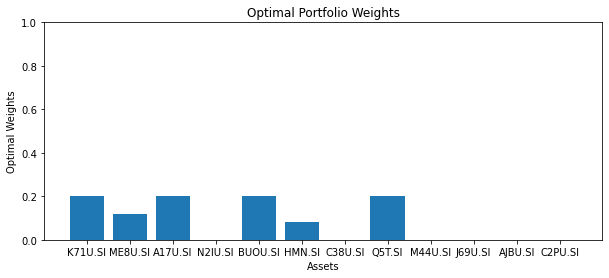

In [31]:
plt.figure(figsize=(10,4))
plt.bar(screened_stocks, optimal_weights)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.ylim([0,1])
plt.title('Optimal Portfolio Weights')